# Phishing Detection Model Training with WandB

This notebook trains and evaluates three phishing detection models:
1. **TF-IDF + Logistic Regression** (baseline)
2. **Hybrid XGBoost** (text embeddings + engineered features)
3. **Hybrid MLP** (text embeddings + engineered features)

All experiments are tracked using Weights & Biases for reproducibility and comparison.

## 1. Install and Import Required Libraries

In [ ]:
import os
import sys
import json
import pickle
from datetime import datetime
from pathlib import Path
import numpy as np
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sentence_transformers import SentenceTransformer
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

c:\Users\jastr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\phishstop-Wtu_n1Ei-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda


## 2. Configure WandB and Experiment Settings

In [ ]:
wandb.login()

config = {
    "random_seed": 42,
    "train_split": 0.6,
    "test_split": 0.2,
    "external_split": 0.2,
    "data_source": "emails_v4.parquet",

    "phishing_threshold": 0.35,
    "class_weight_ratio": 3.0,
    
    "numeric_features": [
        "sender_domain_entropy", "has_attachment",
        "spf_flag_missing", "dkim_flag_missing",
        "num_links", "subject_length", "body_length", "keyword_count", 
        "num_received_headers", "num_exclamation_marks", 
        "num_malicious_links"
    ],
    "embedding_model": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    
    "tfidf_max_features": 5000,
    "tfidf_ngram_range": (1, 2),
    "tfidf_min_df": 5,
    "tfidf_max_df": 0.8,
    "lr_max_iter": 1000,
    "lr_C": 1.0,
    
    "xgb_max_depth": 9,
    "xgb_n_estimators": 300,
    "xgb_learning_rate": 0.1,
    "xgb_min_child_weight": 7,
    "xgb_subsample": 0.85,
    "xgb_colsample_bytree": 0.85,
    "xgb_early_stopping": 20,
    
    "mlp_feature_hidden_dim": 32,
    "mlp_dropout": 0.3,
    "mlp_lr": 0.001,
    "mlp_weight_decay": 1e-4,
    "mlp_epochs": 50,
    "mlp_batch_size": 64,
    "mlp_early_stopping": 10,
}

run = wandb.init(
    project="phishstop-detection",
    name=f"multi-model-training-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config=config,
    tags=["tfidf", "xgboost", "mlp", "hybrid", "comparison", "aggressive-phishing"]
)

print(f"Run URL: {run.url}")
print(f"   - Decision Threshold: {config['phishing_threshold']} (lower = more aggressive)")
print(f"   - Class Weight Ratio: {config['class_weight_ratio']}x penalty for False Negatives")

wandb: Currently logged in as: jastrzeb-michal (latandu-phishstop) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run URL: https://wandb.ai/latandu-phishstop/phishstop-detection/runs/zmajn5bi
   - Decision Threshold: 0.35 (lower = more aggressive)
   - Class Weight Ratio: 3.0x penalty for False Negatives


## 3. Load and Prepare Dataset

In [3]:
# Load dataset
print("Loading dataset...")
df = pl.read_parquet("../../data/emails_v5.parquet")
pl.Config.set_tbl_rows(-1)
print(df.select("source").unique())
print(f"Total records: {len(df):,}")
print(f"Columns: {df.columns}")

# Check class distribution
phishing_count = df.filter(pl.col("phishing") == 1).shape[0]
legit_count = df.filter(pl.col("phishing") == 0).shape[0]

print(f"\nClass distribution:")
print(f"  Phishing: {phishing_count:,} ({phishing_count/len(df)*100:.2f}%)")
print(f"  Legitimate: {legit_count:,} ({legit_count/len(df)*100:.2f}%)")

# Log to WandB
wandb.log({
    "total_records": len(df),
    "phishing_count": phishing_count,
    "legit_count": legit_count,
    "class_balance": phishing_count / len(df)
})

Loading dataset...
shape: (22, 1)
┌───────────────────────┐
│ source                │
│ ---                   │
│ str                   │
╞═══════════════════════╡
│ csv_misc/TREC-05.csv  │
│ phishing-2019         │
│ phishing-2018         │
│ phishing-2015         │
│ csv_misc/CEAS-08.csv  │
│ phishing-2014         │
│ csv_misc/Enron.csv    │
│ phishing-2020         │
│ csv_misc/TREC-07.csv  │
│ phishing-2021         │
│ phishing-2022         │
│ phishing-2024         │
│ csv_misc/Ling.csv     │
│ phishing-2017         │
│ phishing-2016         │
│ mbox_andrunik.mbox    │
│ csv_misc/Assassin.csv │
│ phishing-nigerian     │
│ phishing-2023         │
│ phishing-2013         │
│ mbox_gradzki.mbox     │
│ csv_misc/TREC-06.csv  │
└───────────────────────┘
Total records: 212,113
Columns: ['source', 'phishing', 'spf_flag', 'dkim_flag', 'd_flag', 'return_path_domain', 'body_text', 'has_attachment', 'link_domains', 'receiver_name', 'receiver_email', 'sender_name', 'sender_email', 'sender_domai

## 4. Create Standardized Train/Test/External Splits

In [4]:
# Separate external validation set (CEAS-08 and Enron-DKIM)
print("Creating dataset splits...")


# External validation set: CEAS-08 and Enron-DKIM
external_df = df.filter(
    (pl.col("source") == "csv_misc/TREC-07.csv") | (pl.col("source") == "phishing-2020")
)

# Training pool: everything else
train_pool_df = df.filter(
    (pl.col("source") != "csv_misc/TREC-07.csv") & (pl.col("source") != "phishing-2020")
)

print(f"Training pool: {len(train_pool_df):,}")
print(f"External validation: {len(external_df):,}")

# Convert to pandas for sklearn compatibility
train_pool_pd = train_pool_df.to_pandas()

# Stratified split: 75% train, 25% test from training pool
train_df_pd, test_df_pd = train_test_split(
    train_pool_pd, 
    test_size=0.25, 
    random_state=config["random_seed"], 
    stratify=train_pool_pd['phishing']
)

# Convert back to polars
train_df = pl.from_pandas(train_df_pd)
test_df = pl.from_pandas(test_df_pd)

print(f"\nFinal splits:")
print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  External: {len(external_df):,} ({len(external_df)/len(df)*100:.1f}%)")

# Check class balance in each split
for name, split_df in [("Train", train_df), ("Test", test_df), ("External", external_df)]:
    phish = split_df.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df)
    print(f"\n{name} set:")
    print(f"  Phishing: {phish:,} ({phish/total*100:.2f}%)")
    print(f"  Legitimate: {total-phish:,} ({(total-phish)/total*100:.2f}%)")
    
    wandb.log({
        f"{name.lower()}_size": total,
        f"{name.lower()}_phishing_ratio": phish / total
    })

Creating dataset splits...
Training pool: 158,828
External validation: 53,285

Final splits:
  Train: 119,121 (56.2%)
  Test: 39,707 (18.7%)
  External: 53,285 (25.1%)

Train set:
  Phishing: 49,560 (41.60%)
  Legitimate: 69,561 (58.40%)

Test set:
  Phishing: 16,520 (41.60%)
  Legitimate: 23,187 (58.40%)

External set:
  Phishing: 28,983 (54.39%)
  Legitimate: 24,302 (45.61%)


## 5. Feature Engineering and Extraction

In [5]:
# Extract engineered features
numeric_features = config["numeric_features"]

print(f"Extracting {len(numeric_features)} engineered features...")

features_train = train_df.select(numeric_features).fill_null(0).to_numpy()
features_test = test_df.select(numeric_features).fill_null(0).to_numpy()
features_external = external_df.select(numeric_features).fill_null(0).to_numpy()

print(f"\nFeature shapes:")
print(f"  Train: {features_train.shape}")
print(f"  Test: {features_test.shape}")
print(f"  External: {features_external.shape}")

# Feature statistics
feature_stats = {}
for i, feat_name in enumerate(numeric_features):
    stats = {
        "mean": float(features_train[:, i].mean()),
        "std": float(features_train[:, i].std()),
        "min": float(features_train[:, i].min()),
        "max": float(features_train[:, i].max())
    }
    feature_stats[feat_name] = stats
    print(f"  {feat_name}: mean={stats['mean']:.3f}, std={stats['std']:.3f}")

wandb.log({"feature_statistics": wandb.Table(
    columns=["feature", "mean", "std", "min", "max"],
    data=[[k, v["mean"], v["std"], v["min"], v["max"]] for k, v in feature_stats.items()]
)})

Extracting 11 engineered features...

Feature shapes:
  Train: (119121, 11)
  Test: (39707, 11)
  External: (53285, 11)
  sender_domain_entropy: mean=0.522, std=0.277
  has_attachment: mean=0.002, std=0.040
  spf_flag_missing: mean=0.002, std=0.044
  dkim_flag_missing: mean=0.004, std=0.064
  num_links: mean=0.002, std=0.014
  subject_length: mean=0.005, std=0.004
  body_length: mean=0.001, std=0.005
  keyword_count: mean=0.000, std=0.003
  num_received_headers: mean=0.018, std=0.065
  num_exclamation_marks: mean=0.054, std=0.091
  num_malicious_links: mean=0.000, std=0.006


## 6. Generate Text Embeddings

In [6]:
# Load sentence transformer model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Generating embeddings on {device}...")

embedding_model = SentenceTransformer(config["embedding_model"], device=device)

# Generate embeddings for each split
print("Encoding train set...")
X_emb_train = embedding_model.encode(
    train_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding test set...")
X_emb_test = embedding_model.encode(
    test_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

print("Encoding external set...")
X_emb_external = embedding_model.encode(
    external_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

# Extract labels
y_train = train_df['phishing'].to_numpy()
y_test = test_df['phishing'].to_numpy()
y_external = external_df['phishing'].to_numpy()

print(f"\nEmbedding shapes:")
print(f"  Train: {X_emb_train.shape}")
print(f"  Test: {X_emb_test.shape}")
print(f"  External: {X_emb_external.shape}")

wandb.log({
    "embedding_dim": X_emb_train.shape[1],
    "embedding_model": config["embedding_model"]
})

Generating embeddings on cuda...
Encoding train set...


Batches: 100%|██████████| 3723/3723 [02:20<00:00, 26.42it/s] 


Encoding test set...


Batches: 100%|██████████| 1241/1241 [00:45<00:00, 27.45it/s] 


Encoding external set...


Batches: 100%|██████████| 1666/1666 [01:04<00:00, 25.82it/s]



Embedding shapes:
  Train: (119121, 384)
  Test: (39707, 384)
  External: (53285, 384)


## 7. Train TF-IDF Baseline Model

Combined feature shape: (119121, 5011)
  TF-IDF features: 5000
  Engineered features: 11

 Using class weights: {0: 1.0, 1: 3.0} (phishing class gets 3.0x weight)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished



 Using phishing threshold: 0.35 (default is 0.5)

Test Set Metrics (threshold=0.35):
  accuracy: 0.9555
  precision: 0.9093
  recall: 0.9920
  f1: 0.9488
  roc_auc: 0.9963

External Set Metrics (threshold=0.35):
  accuracy: 0.9126
  precision: 0.8956
  recall: 0.9500
  f1: 0.9220
  roc_auc: 0.9616
 1. right to                       -12.911601
 2. aggressive                     -10.598795
 3. sm                             -10.525958
 4. thus                           +7.748507
 5. num_links                      -7.604038
 6. to that                        +7.516887
 7. project                        -7.077321
 8. flights                        -6.739763
 9. 2nd                            -6.713078
10. in their                       -6.231632
11. driven                         +5.877720
12. programming                    -5.861189
13. derivatives                    -5.781867
14. ankle                          -5.777213
15. brian                          -5.768583
16. material          

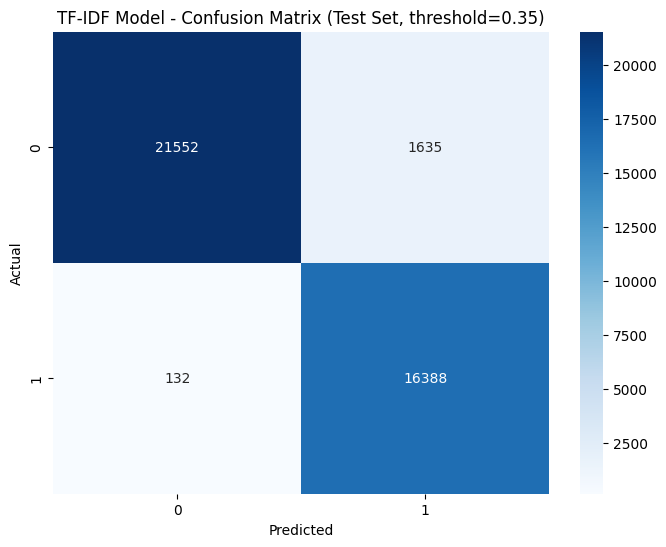

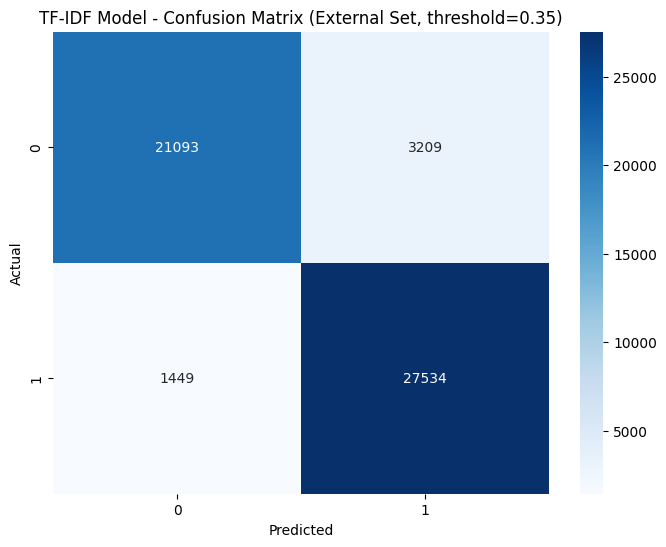

In [7]:
from scipy.sparse import hstack
tfidf = TfidfVectorizer(
    max_features=config["tfidf_max_features"],
    ngram_range=config["tfidf_ngram_range"],
    min_df=config["tfidf_min_df"],
    max_df=config["tfidf_max_df"]
)


X_tfidf_train = tfidf.fit_transform(train_df['body_subject'].to_list())
X_tfidf_test = tfidf.transform(test_df['body_subject'].to_list())
X_tfidf_external = tfidf.transform(external_df['body_subject'].to_list())

X_combined_train = hstack([X_tfidf_train, features_train])
X_combined_test = hstack([X_tfidf_test, features_test])
X_combined_external = hstack([X_tfidf_external, features_external])

print(f"Combined feature shape: {X_combined_train.shape}")
print(f"  TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

# AGGRESSIVE: Use class weights to heavily penalize missing phishing emails
class_weights = {0: 1.0, 1: config['class_weight_ratio']}
print(f"\n Using class weights: {class_weights} (phishing class gets {config['class_weight_ratio']}x weight)")

lr_clf = LogisticRegression(
    max_iter=config["lr_max_iter"],
    C=config["lr_C"],
    class_weight=class_weights,  # AGGRESSIVE: Penalize False Negatives
    random_state=config["random_seed"],
    verbose=1
)
lr_clf.fit(X_combined_train, y_train)

# AGGRESSIVE: Use lower threshold for phishing classification
phishing_threshold = config['phishing_threshold']
print(f"\n Using phishing threshold: {phishing_threshold} (default is 0.5)")

# Evaluate on test set
y_proba_test_tfidf = lr_clf.predict_proba(X_combined_test)[:, 1]
y_pred_test_tfidf = (y_proba_test_tfidf >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

tfidf_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_tfidf),
    'precision': precision_score(y_test, y_pred_test_tfidf, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_tfidf, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_tfidf)
}

print(f"\nTest Set Metrics (threshold={phishing_threshold}):")
for metric, value in tfidf_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
y_proba_ext_tfidf = lr_clf.predict_proba(X_combined_external)[:, 1]
y_pred_ext_tfidf = (y_proba_ext_tfidf >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

tfidf_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_tfidf),
    'precision': precision_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_tfidf)
}

print(f"\nExternal Set Metrics (threshold={phishing_threshold}):")
for metric, value in tfidf_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

feature_names = list(tfidf.vocabulary_.keys()) + numeric_features
coefficients = lr_clf.coef_[0]
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)

for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {coef:+.6f}")

# Log to WandB
wandb.log({
    "tfidf/phishing_threshold": phishing_threshold,
    "tfidf/class_weight_ratio": config['class_weight_ratio'],
    "tfidf/test_accuracy": tfidf_test_metrics['accuracy'],
    "tfidf/test_precision": tfidf_test_metrics['precision'],
    "tfidf/test_recall": tfidf_test_metrics['recall'],
    "tfidf/test_f1": tfidf_test_metrics['f1'],
    "tfidf/test_roc_auc": tfidf_test_metrics['roc_auc'],
    "tfidf/external_accuracy": tfidf_external_metrics['accuracy'],
    "tfidf/external_precision": tfidf_external_metrics['precision'],
    "tfidf/external_recall": tfidf_external_metrics['recall'],
    "tfidf/external_f1": tfidf_external_metrics['f1'],
    "tfidf/external_roc_auc": tfidf_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()


## 8. Train Hybrid XGBoost Model

Combined feature shape: (119121, 395)
  Full embeddings: 384
  Engineered features: 11

 Using scale_pos_weight: 3.0 (penalizes missing phishing emails)

Training XGBoost...
[0]	validation_0-logloss:0.73642	validation_0-auc:0.93584	validation_1-logloss:0.73910	validation_1-auc:0.92225
[10]	validation_0-logloss:0.35691	validation_0-auc:0.99015	validation_1-logloss:0.37905	validation_1-auc:0.98075
[20]	validation_0-logloss:0.21704	validation_0-auc:0.99578	validation_1-logloss:0.24852	validation_1-auc:0.98809
[30]	validation_0-logloss:0.14687	validation_0-auc:0.99795	validation_1-logloss:0.18402	validation_1-auc:0.99138
[40]	validation_0-logloss:0.10600	validation_0-auc:0.99897	validation_1-logloss:0.14625	validation_1-auc:0.99335
[50]	validation_0-logloss:0.08169	validation_0-auc:0.99944	validation_1-logloss:0.12455	validation_1-auc:0.99441
[60]	validation_0-logloss:0.06350	validation_0-auc:0.99971	validation_1-logloss:0.10738	validation_1-auc:0.99538
[70]	validation_0-logloss:0.05190	va

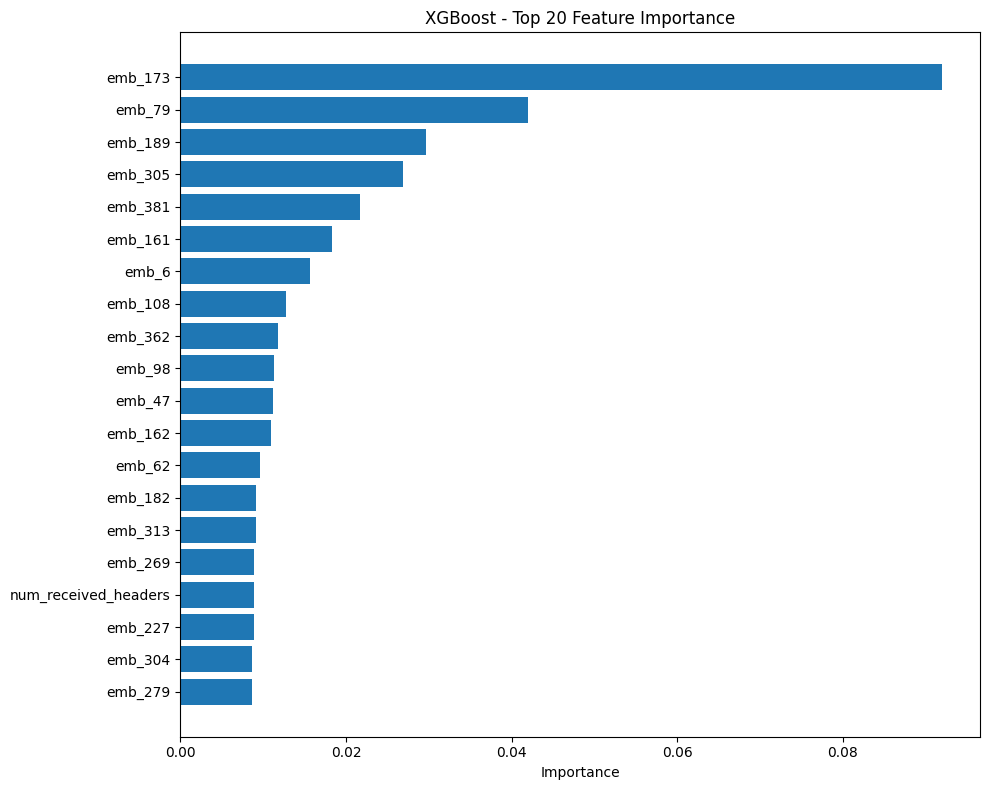

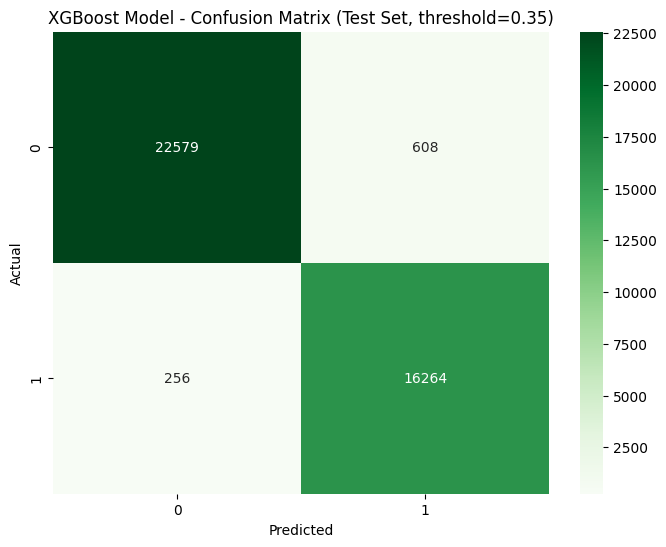

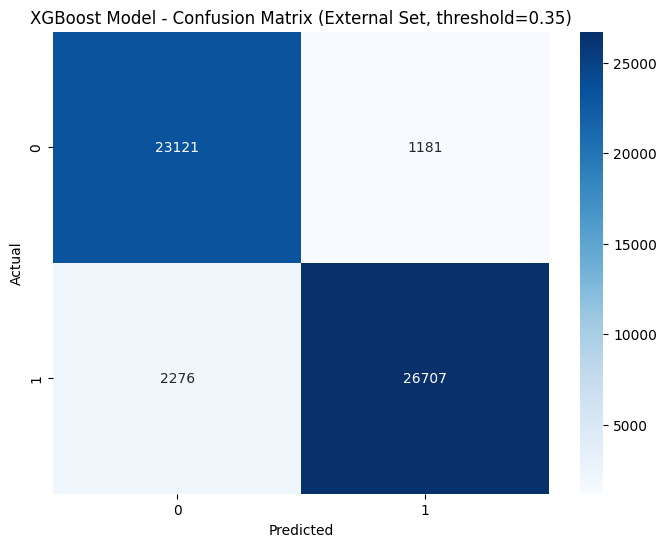

In [8]:
X_xgb_train = np.concatenate([X_emb_train, features_train], axis=1)
X_xgb_test = np.concatenate([X_emb_test, features_test], axis=1)
X_xgb_external = np.concatenate([X_emb_external, features_external], axis=1)

print(f"Combined feature shape: {X_xgb_train.shape}")
print(f"  Full embeddings: {X_emb_train.shape[1]}")
print(f"  Engineered features: {features_train.shape[1]}")

# AGGRESSIVE: Calculate scale_pos_weight to penalize False Negatives
scale_pos_weight = config['class_weight_ratio']
print(f"\n Using scale_pos_weight: {scale_pos_weight} (penalizes missing phishing emails)")

# Train XGBoost with WandB callback
xgb_clf = xgb.XGBClassifier(
    max_depth=config["xgb_max_depth"],
    n_estimators=config["xgb_n_estimators"],
    learning_rate=config["xgb_learning_rate"],
    min_child_weight=config["xgb_min_child_weight"],
    subsample=config["xgb_subsample"],
    colsample_bytree=config["xgb_colsample_bytree"],
    scale_pos_weight=scale_pos_weight,  # AGGRESSIVE: Penalize False Negatives
    random_state=config["random_seed"],
    eval_metric=["logloss", "auc"],
    early_stopping_rounds=config["xgb_early_stopping"],
    callbacks=[wandb.xgboost.WandbCallback(log_model=True)]
)

print("\nTraining XGBoost...")
xgb_clf.fit(
    X_xgb_train, y_train,
    eval_set=[(X_xgb_train, y_train), (X_xgb_test, y_test)],
    verbose=10
)

# AGGRESSIVE: Use lower threshold for phishing classification
phishing_threshold = config['phishing_threshold']
print(f"\n Using phishing threshold: {phishing_threshold} (default is 0.5)")

# Evaluate on test set
y_proba_test_xgb = xgb_clf.predict_proba(X_xgb_test)[:, 1]
y_pred_test_xgb = (y_proba_test_xgb >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

xgb_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_xgb),
    'precision': precision_score(y_test, y_pred_test_xgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_xgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_xgb, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_xgb)
}

print(f"\nTest Set Metrics (threshold={phishing_threshold}):")
for metric, value in xgb_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
y_proba_ext_xgb = xgb_clf.predict_proba(X_xgb_external)[:, 1]
y_pred_ext_xgb = (y_proba_ext_xgb >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

xgb_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_xgb),
    'precision': precision_score(y_external, y_pred_ext_xgb, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_xgb, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_xgb, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_xgb)
}

print(f"\nExternal Set Metrics (threshold={phishing_threshold}):")
for metric, value in xgb_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Log to WandB
wandb.log({
    "xgboost/phishing_threshold": phishing_threshold,
    "xgboost/scale_pos_weight": scale_pos_weight,
    "xgboost/test_accuracy": xgb_test_metrics['accuracy'],
    "xgboost/test_precision": xgb_test_metrics['precision'],
    "xgboost/test_recall": xgb_test_metrics['recall'],
    "xgboost/test_f1": xgb_test_metrics['f1'],
    "xgboost/test_roc_auc": xgb_test_metrics['roc_auc'],
    "xgboost/external_accuracy": xgb_external_metrics['accuracy'],
    "xgboost/external_precision": xgb_external_metrics['precision'],
    "xgboost/external_recall": xgb_external_metrics['recall'],
    "xgboost/external_f1": xgb_external_metrics['f1'],
    "xgboost/external_roc_auc": xgb_external_metrics['roc_auc'],
})

feature_names = [f"emb_{i}" for i in range(X_emb_train.shape[1])] + numeric_features
importance = xgb_clf.feature_importances_
feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print("\nTop 20 Important Features:")
for i, (name, imp) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {imp:.6f}")

fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance[:20]
ax.barh([f[0] for f in top_features][::-1], [f[1] for f in top_features][::-1])
ax.set_xlabel('Importance')
ax.set_title('XGBoost - Top 20 Feature Importance')
plt.tight_layout()
wandb.log({"xgboost/feature_importance": wandb.Image(fig)})
plt.show()
plt.close()

# Confusion matrix for XGBoost
cm = confusion_matrix(y_test, y_pred_test_xgb)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax_cm)
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('Actual')
ax_cm.set_title(f'XGBoost Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig_cm)})
plt.show()
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_xgb)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'XGBoost Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"xgboost/confusion_matrix": wandb.Image(fig)})
plt.close()


## 9. Train Hybrid MLP Model

In [9]:
from hybrid_mlp_model import HybridMLPClassifier

X_emb_train_fit, X_emb_val, X_feat_train_fit, X_feat_val, y_train_fit, y_val = train_test_split(
    X_emb_train, features_train, y_train, 
    test_size=0.2, 
    random_state=config["random_seed"], 
    stratify=y_train
)

print(f"Train: {X_emb_train_fit.shape[0]} | Val: {X_emb_val.shape[0]} | Test: {X_emb_test.shape[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = HybridMLPClassifier(
    embedding_dim=config["embedding_dim"],
    num_features=len(numeric_features),
    feature_hidden_dim=config["mlp_feature_hidden_dim"],
    dropout=config["mlp_dropout"]
).to(device)

print(mlp_model)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

# Create data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_emb_train_fit),
    torch.FloatTensor(X_feat_train_fit),
    torch.FloatTensor(y_train_fit)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_emb_val),
    torch.FloatTensor(X_feat_val),
    torch.FloatTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_emb_test),
    torch.FloatTensor(features_test),
    torch.FloatTensor(y_test)
)

train_loader = DataLoader(train_dataset, batch_size=config["mlp_batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["mlp_batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

# Training setup
optimizer = torch.optim.Adam(
    mlp_model.parameters(), 
    lr=config["mlp_lr"], 
    weight_decay=config["mlp_weight_decay"]
)

# AGGRESSIVE: Use weighted loss to heavily penalize False Negatives (missing phishing)
pos_weight = torch.tensor([config['class_weight_ratio']], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(f"\n⚠️  Using weighted BCE loss with pos_weight={config['class_weight_ratio']} (penalizes False Negatives)")

# Training loop
best_val_loss = float('inf')
patience_counter = 0

print("\nTraining MLP...")
for epoch in range(config["mlp_epochs"]):
    # Training
    mlp_model.train()
    train_loss = 0
    for embeddings, features, labels in train_loader:
        embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = mlp_model(embeddings, features).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    mlp_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            logits = mlp_model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            val_preds.extend(probs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_pred_binary = (val_preds > 0.5).astype(int)
    
    val_acc = accuracy_score(val_labels, val_pred_binary)
    val_f1 = f1_score(val_labels, val_pred_binary, zero_division=0)
    
    # Log to WandB
    wandb.log({
        "mlp/epoch": epoch,
        "mlp/train_loss": train_loss,
        "mlp/val_loss": val_loss,
        "mlp/val_accuracy": val_acc,
        "mlp/val_f1": val_f1
    })
    
    print(f"Epoch {epoch+1}/{config['mlp_epochs']}: "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = mlp_model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= config["mlp_early_stopping"]:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
mlp_model.load_state_dict(best_model_state)

Train: 95296 | Val: 23825 | Test: 39707
HybridMLPClassifier(
  (feature_branch): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=416, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 140,161

⚠️  Using weighted BCE loss with pos_weight=3.0 (penalizes False Negatives)

Training MLP...
Epoch 1/50: Train Loss: 0.2525 | Val Loss: 0.1473 | Val Acc: 0.9624 | Val F1: 0.9560
Epoch 2/50: Train Loss: 0.1366 | Val Loss: 0.1148 | Val Acc: 0.9717 | Val F1: 0.9665
Epoch 3/50: Train Loss: 0.1070 | Val Loss: 0.1063 | Val Acc: 0.9724 | Val F1: 0.9675
Epoch 4/50: Train Loss: 0.0906 | Val Loss: 0.1011 | Val Acc: 0.9768 | Val F1: 0.9725

<All keys matched successfully>


 Using phishing threshold: 0.35 (default is 0.5)

MLP Test Set Metrics (threshold=0.35):
  accuracy: 0.9685
  precision: 0.9366
  recall: 0.9915
  f1: 0.9633
  roc_auc: 0.9978

MLP External Set Metrics (threshold=0.35):
  accuracy: 0.9311
  precision: 0.9314
  recall: 0.9428
  f1: 0.9370
  roc_auc: 0.9807


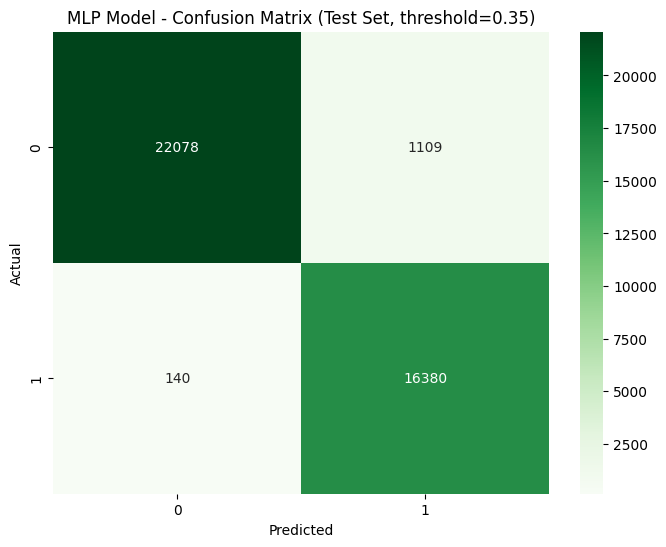

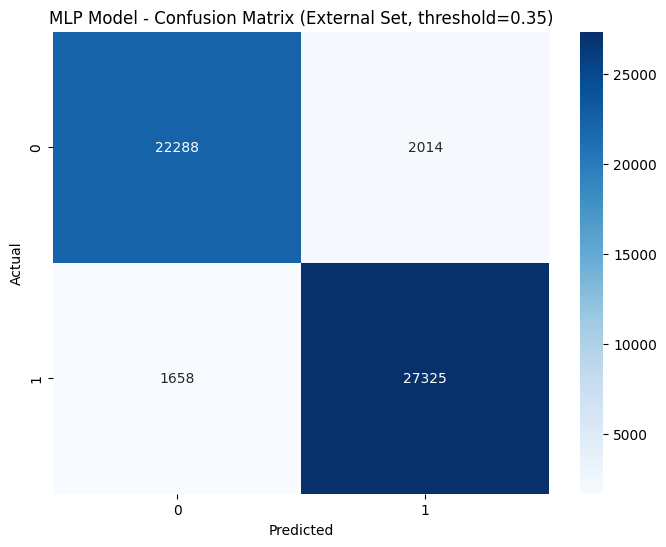

In [10]:
# AGGRESSIVE: Use lower threshold for phishing classification
phishing_threshold = config['phishing_threshold']
print(f"\n Using phishing threshold: {phishing_threshold} (default is 0.5)")

# Evaluate MLP on test set
mlp_model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

mlp_test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

print(f"\nMLP Test Set Metrics (threshold={phishing_threshold}):")
for metric, value in mlp_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on external set
external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        # Handle both batch and single samples
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs >= phishing_threshold).astype(int)  # AGGRESSIVE threshold

mlp_external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"\nMLP External Set Metrics (threshold={phishing_threshold}):")
for metric, value in mlp_external_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Log to WandB
wandb.log({
    "mlp/phishing_threshold": phishing_threshold,
    "mlp/pos_weight": config['class_weight_ratio'],
    "mlp/test_accuracy": mlp_test_metrics['accuracy'],
    "mlp/test_precision": mlp_test_metrics['precision'],
    "mlp/test_recall": mlp_test_metrics['recall'],
    "mlp/test_f1": mlp_test_metrics['f1'],
    "mlp/test_roc_auc": mlp_test_metrics['roc_auc'],
    "mlp/external_accuracy": mlp_external_metrics['accuracy'],
    "mlp/external_precision": mlp_external_metrics['precision'],
    "mlp/external_recall": mlp_external_metrics['recall'],
    "mlp/external_f1": mlp_external_metrics['f1'],
    "mlp/external_roc_auc": mlp_external_metrics['roc_auc'],
})

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()
plt.close()

## 10. Compare Model Performance

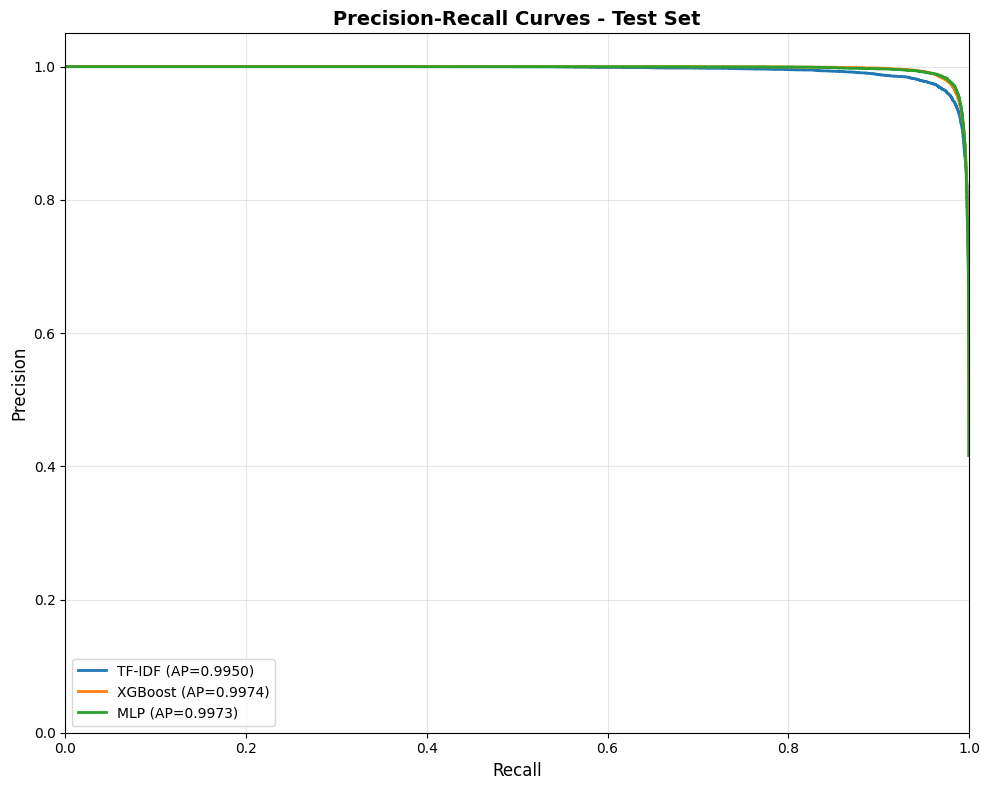

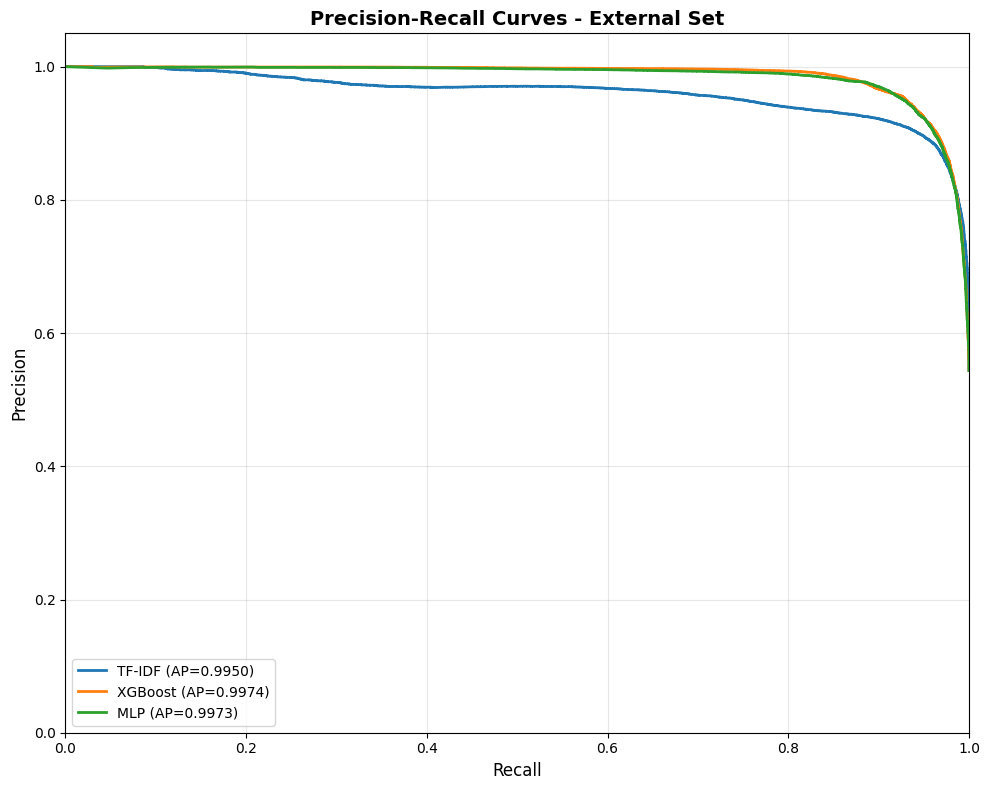


TEST SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9555       0.9093       0.9920       0.9488       0.9963      
XGBoost Hybrid       0.9782       0.9640       0.9845       0.9741       0.9979      
MLP Hybrid           0.9685       0.9366       0.9915       0.9633       0.9978      

EXTERNAL VALIDATION SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
TF-IDF + LogReg      0.9126       0.8956       0.9500       0.9220       0.9616      
XGBoost Hybrid       0.9351       0.9577       0.9215       0.9392       0.9822      
MLP Hybrid           0.9311       0.9314       0.9428       0.9370       0.9807      


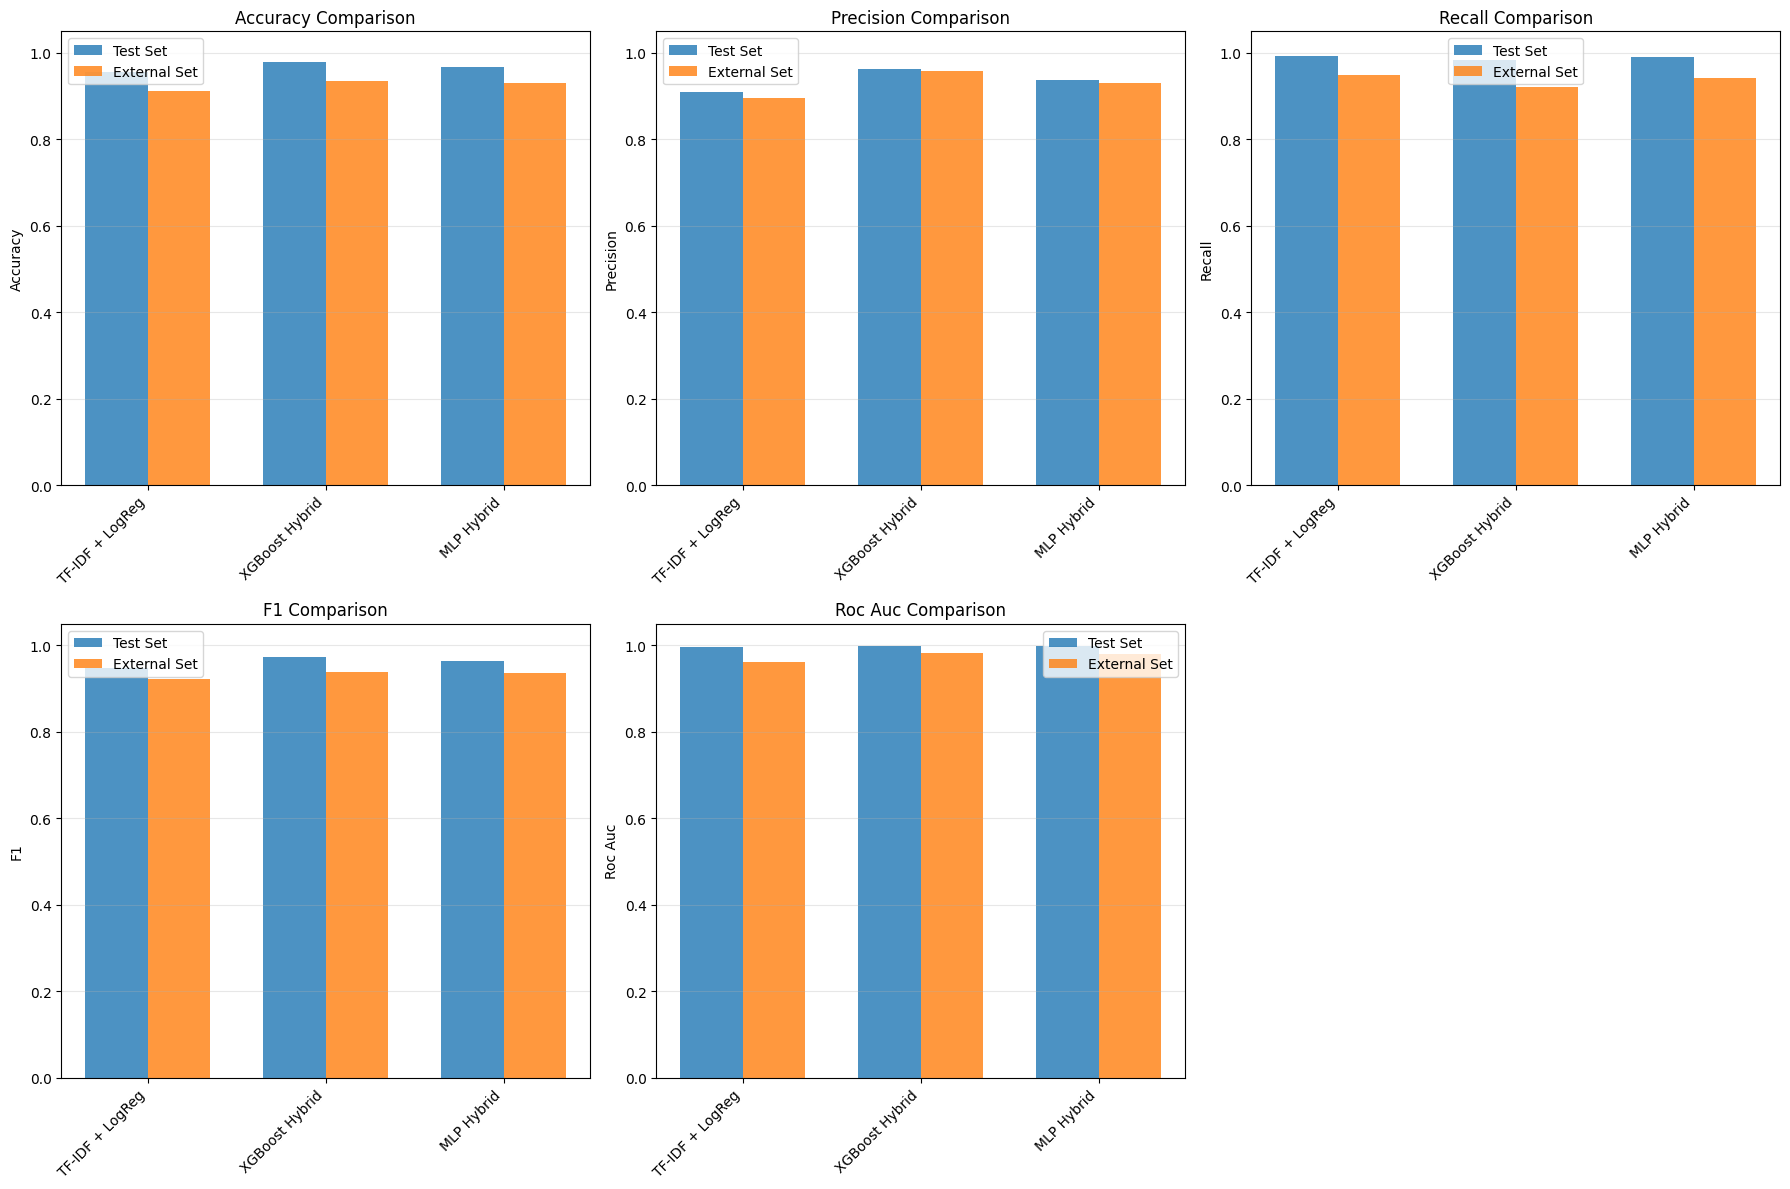

In [11]:
# Create comprehensive comparison
comparison_data = {
    'TF-IDF + LogReg': {
        'test': tfidf_test_metrics,
        'external': tfidf_external_metrics
    },
    'XGBoost Hybrid': {
        'test': xgb_test_metrics,
        'external': xgb_external_metrics
    },
    'MLP Hybrid': {
        'test': mlp_test_metrics,
        'external': mlp_external_metrics
    }
}

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate PR curves
tfidf_precision_test, tfidf_recall_test, _ = precision_recall_curve(y_test, y_proba_test_tfidf)
xgb_precision_test, xgb_recall_test, _ = precision_recall_curve(y_test, y_proba_test_xgb)
mlp_precision_test, mlp_recall_test, _ = precision_recall_curve(test_labels, test_probs)

tfidf_precision_ex, tfidf_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_tfidf)
xgb_precision_ex, xgb_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_xgb)
mlp_precision_ex, mlp_recall_ex, _ = precision_recall_curve(ext_labels, ext_probs)


# Calculate average precision
tfidf_ap = average_precision_score(y_test, y_proba_test_tfidf)
xgb_ap = average_precision_score(y_test, y_proba_test_xgb)
mlp_ap = average_precision_score(test_labels, test_probs)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_test, tfidf_precision_test, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_test, xgb_precision_test, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_test, mlp_precision_test, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_ex, tfidf_precision_ex, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_ex, xgb_precision_ex, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_ex, mlp_precision_ex, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - External Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

# Test set comparison
print("\nTEST SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    test_m = metrics['test']
    print(f"{model_name:<20} {test_m['accuracy']:<12.4f} {test_m['precision']:<12.4f} "
          f"{test_m['recall']:<12.4f} {test_m['f1']:<12.4f} {test_m['roc_auc']:<12.4f}")

# External set comparison
print("\nEXTERNAL VALIDATION SET PERFORMANCE:")
print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)
for model_name, metrics in comparison_data.items():
    ext_m = metrics['external']
    print(f"{model_name:<20} {ext_m['accuracy']:<12.4f} {ext_m['precision']:<12.4f} "
          f"{ext_m['recall']:<12.4f} {ext_m['f1']:<12.4f} {ext_m['roc_auc']:<12.4f}")

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    models = list(comparison_data.keys())
    test_values = [comparison_data[m]['test'][metric] for m in models]
    external_values = [comparison_data[m]['external'][metric] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax.bar(x - width/2, test_values, width, label='Test Set', alpha=0.8)
    ax.bar(x + width/2, external_values, width, label='External Set', alpha=0.8)
    
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
wandb.log({"comparison/metrics_comparison": wandb.Image(fig)})
plt.show()

comparison_table_data = []
for model_name, metrics in comparison_data.items():
    for split, split_metrics in metrics.items():
        row = [model_name, split] + [split_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
        comparison_table_data.append(row)

comparison_table = wandb.Table(
    columns=['Model', 'Split', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'],
    data=comparison_table_data
)
wandb.log({"comparison/performance_table": comparison_table})


## 11. Save Models and Artifacts


In [12]:
# Create directories
os.makedirs("../../output/saved_models", exist_ok=True)
os.makedirs("../../output/saved_artifacts", exist_ok=True)

print("Saving models and artifacts...")

with open('../../output/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('../../output/saved_models/tfidf_classifier.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

xgb_clf.save_model('../../output/saved_models/xgboost_hybrid.json')

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'embedding_dim': config["embedding_dim"],
    'num_features': len(numeric_features),
    'feature_hidden_dim': config["mlp_feature_hidden_dim"],
    'dropout': config["mlp_dropout"],
    'test_metrics': mlp_test_metrics,
    'external_metrics': mlp_external_metrics,
    'phishing_threshold': config['phishing_threshold'],  # AGGRESSIVE: Save threshold
    'class_weight_ratio': config['class_weight_ratio']   # AGGRESSIVE: Save class weight
}, '../../output/saved_models/mlp_hybrid.pth')

# Save experiment configuration
full_config = {
    'experiment_config': config,
    'aggressive_settings': {
        'phishing_threshold': config['phishing_threshold'],
        'class_weight_ratio': config['class_weight_ratio'],
        'description': 'Models trained with aggressive phishing detection - lower threshold and higher penalties for False Negatives'
    },
    'data_splits': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'external_size': len(external_df)
    },
    'model_performance': {
        'tfidf': {
            'test': {k: float(v) for k, v in tfidf_test_metrics.items()},
            'external': {k: float(v) for k, v in tfidf_external_metrics.items()}
        },
        'xgboost': {
            'test': {k: float(v) for k, v in xgb_test_metrics.items()},
            'external': {k: float(v) for k, v in xgb_external_metrics.items()}
        },
        'mlp': {
            'test': {k: float(v) for k, v in mlp_test_metrics.items()},
            'external': {k: float(v) for k, v in mlp_external_metrics.items()}
        }
    },
    'feature_names': numeric_features,
    'timestamp': datetime.now().isoformat()
}

with open('../../output/saved_artifacts/experiment_config.json', 'w') as f:
    json.dump(full_config, f, indent=2)

print("\nSaved aggressive phishing detection settings:")
print(f"   - Threshold: {config['phishing_threshold']}")
print(f"   - Class Weight Ratio: {config['class_weight_ratio']}")

# Upload artifacts to WandB
artifact = wandb.Artifact('phishstop-models-aggressive', type='model')
artifact.add_dir('../../output/saved_models')
artifact.add_file('../../output/saved_artifacts/experiment_config.json')
wandb.log_artifact(artifact)



wandb: Adding directory to artifact (..\..\output\saved_models)... 

Saving models and artifacts...

Saved aggressive phishing detection settings:
   - Threshold: 0.35
   - Class Weight Ratio: 3.0


Done. 0.1s


<Artifact phishstop-models-aggressive>

In [13]:
# Finish WandB run
wandb.finish()
print("✓ WandB run completed")

best_iteration,▁
best_score,▁
class_balance,▁
embedding_dim,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████
external_phishing_ratio,▁
external_size,▁
legit_count,▁
mlp/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
mlp/external_accuracy,▁
+49,...


✓ WandB run completed
